# Will It Rain Tomorrow? Predicting Rainfall with Machine Learning

## Project Overview
This project explores the task of predicting whether it will rain tomorrow using historical weather data collected across Australia. Accurate short-term rainfall forecasting is valuable for sectors such as agriculture, logistics, and emergency preparedness.

## Problem Statement
The goal is to build a binary classification model that predicts the likelihood of rainfall on the following day, enabling improved planning and decision-making for weather-dependent activities.

## Methodology
A machine learning pipeline was implemented using scikit-learn to preprocess the data, engineer features, and train classification models. The pipeline was then optimized using grid search and cross-validation, and evaluated based on classification metrics and confusion matrices.

## Tools and Techniques
The project demonstrates an end-to-end workflow including:
- Data cleaning and preprocessing
- Feature selection and encoding
- Model training and optimization
- Performance evaluation using classification metrics

All tasks were completed using open-source tools in Python.


## Dataset Overview

The dataset spans multiple years and contains daily weather observations from various Australian locations, including variables such as wind, temperature, humidity, pressure, and rainfall. The target variable is `RainTomorrow`, a binary label indicating whether it rained the following day.

Source: [Australian Bureau of Meteorology via Kaggle](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package)


In [ ]:
# Importing libraries for data manipulation, visualization, and model building

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

## Data Preparation

Load the dataset and perform initial inspection and cleaning to prepare it for modeling.

In [4]:
df = pd.read_csv("../data/Rainfall_Australia.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Preliminary Data Inspection

Examine the dataset’s structure, feature types, and missing values to inform cleaning and preprocessing steps.

In [ ]:
df.shape #Check size of the dataset

(145460, 23)

In [ ]:
df.columns #View column headers

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [ ]:
df.info() #Check datatype and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
df["RainTomorrow"].value_counts() #Examine class distribution of the target variable

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

In [ ]:
df.isnull().sum() #Identify missing values across columns

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

## Preliminary Insights

The dataset contains 23 features and 145,460 records. Several features include missing values, and the target variable `RainTomorrow` is slightly imbalanced, with more 'No' than 'Yes' instances.


## Data Cleaning and Imputation

Instead of dropping rows with missing values, we retained the full dataset by applying imputation strategies:

- **Numeric features** were imputed with the median value to reduce the influence of outliers.
- **Categorical features** were imputed with the most frequent (mode) value.

This approach maintains dataset size and supports reproducibility during model training.


In [13]:
# Percentage of missing values before imputation
missing_before = (df.isnull().sum() / len(df)).sort_values(ascending=False)
missing_before[missing_before > 0]

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
WindSpeed9am     0.012148
Temp9am          0.012148
MinTemp          0.010209
MaxTemp          0.008669
dtype: float64

In [ ]:


# Separate numeric and categorical features
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Impute numeric columns with median
num_imputer = SimpleImputer(strategy='median')
df[numeric_features] = num_imputer.fit_transform(df[numeric_features])

# Impute categorical columns with most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])


In [15]:
# Confirm no missing values remain
df.isnull().sum().sum()  # Should return 0

np.int64(0)

### Imputation Summary

Prior to imputation, several features contained missing values, with some attributes like `Sunshine` and `Evaporation` showing moderate levels of nulls.

After applying median-based imputation for numerical features and mode-based imputation for categorical features, the dataset is now fully complete with no missing values.


## Feature Engineering: Extracting Seasonal Information

Weather patterns often follow seasonal trends, especially in a country like Australia where seasons are well-defined and reversed compared to the northern hemisphere. To capture this pattern, we extracted a new categorical feature `Season` from the `Date` column.

This feature may help the model better understand recurring patterns in rainfall likelihood across different times of the year.

Once the `Season` feature was created, the original `Date` column was dropped, as it was no longer directly informative for prediction.


In [16]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define function to map month to season (Southern Hemisphere)
def date_to_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

# Create new 'Season' feature and drop 'Date'
df['Season'] = df['Date'].apply(date_to_season)
df.drop('Date', axis=1, inplace=True)


In [17]:
df['Season'].value_counts()

Season
Autumn    38264
Winter    36737
Spring    35337
Summer    35122
Name: count, dtype: int64

## Train-Test Split

To evaluate model performance reliably, we split the dataset into training and testing subsets. The training set will be used to fit the model, while the test set will serve to assess its performance on unseen data.

In [19]:
X = df.drop(columns='RainTomorrow', axis=1)
y = df['RainTomorrow']


In [20]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Preprocessing Pipeline Setup

To prepare the dataset for modeling, numerical and categorical features are preprocessed using separate pipelines:
- Numerical features are standardized using `StandardScaler`
- Categorical features are encoded using `OneHotEncoder`, with unseen categories ignored during inference

These preprocessing steps are bundled into a `ColumnTransformer`, enabling seamless integration with the modeling pipeline.

In [21]:
# Detect feature type

numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


In [ ]:
# Define separate transformers for both feature types and combine them into a single preprocessing transformer


# Scale the numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

In [24]:
# Combine the transformers into a single preprocessing column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Model Pipeline: Random Forest Classifier

We created a complete pipeline that combines preprocessing steps with a classification model. This ensures that all transformations are applied consistently during both training and prediction.

The initial model used is a `RandomForestClassifier` as a strong baseline, given its robustness to feature scaling, non-linear patterns, and class imbalance.


In [ ]:
# Define the model pipeline

rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the pipeline on the training data
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'WindGustDir',
                                                   'WindDir9am', 'WindDir3pm',
                                                   'RainToday', 'Season'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

## Model Optimization: Grid Search with Stratified Cross-Validation

To improve model performance, we used `GridSearchCV` to perform hyperparameter tuning across multiple configurations of the `RandomForestClassifier`. The search was conducted using 5-fold stratified cross-validation to ensure class balance within each fold.

Due to the size of the dataset and the computational cost of tree-based models, we used a reduced parameter grid to balance optimization with execution time. This allowed us to validate the model pipeline efficiently while still exploring meaningful parameter combinations.


In [29]:
# define parameter grid

param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [2],
}


In [30]:
#Define stratified Cross-Validation

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## Exercise 9. Instantiate and fit GridSearchCV to the pipeline
Complete the followng code:  
```python
grid_search = GridSearchCV(..., param_grid, cv=..., scoring='accuracy', verbose=2)  
grid_search.fit(..., ...)
```


In [31]:
# Set up GridSearchCV

grid_search = GridSearchCV(
    estimator=rf_pipeline, 
    param_grid=param_grid, 
    cv=cv_strategy, 
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pre...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainToday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, None],
                         'classifier__min_samples_split': [2],
                         'classifier__n_estimators': [100]},
             scoring='accuracy', verbose=1)

## Model Evaluation

After hyperparameter tuning, the optimized Random Forest model was evaluated on the test set. The performance was assessed using accuracy, a classification report, and a confusion matrix to understand the model's ability to predict rainfall events correctly.

In [32]:
# Retrieve the best model (with optimal hyperparameters) from the grid search

best_model = grid_search.best_estimator_

In [40]:
# Best parameters and CV Score

print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.4f}")



Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.85
Test Set Accuracy: 0.8584


Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.96      0.91     22717
         Yes       0.78      0.50      0.61      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.73      0.76     29092
weighted avg       0.85      0.86      0.85     29092



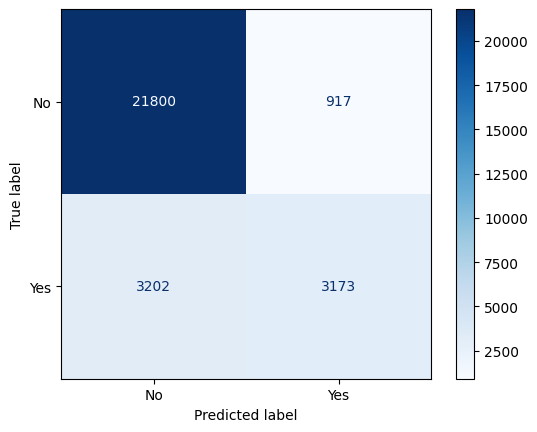

In [41]:


# Predict on test set
y_pred = best_model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")


In [42]:

test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.86


## Results and Key Insights

The optimized Random Forest model achieved an accuracy of 85.8% on the test set. Performance was notably strong for predicting non-rainy days (`RainTomorrow = No`), with a precision of 0.87 and recall of 0.96.

However, the model was less effective at identifying rainy days (`RainTomorrow = Yes`), achieving only 0.50 recall. This indicates the model is conservative in predicting rainfall, likely favoring precision over recall to avoid false positives.

While this behavior may be acceptable for some applications, in high-stakes scenarios (e.g., agriculture or logistics), missing rainy days could be costly. Future iterations could benefit from:
- Adjusting class weights
- Optimizing for F1-score or recall
- Exploring resampling techniques such as SMOTE


## Feature Importance Analysis

To better understand the model's decision-making process, we analyzed the feature importances from the optimized Random Forest classifier. Numerical features were used as-is, while categorical features were one-hot encoded before training. 

The plot below highlights the top 20 most influential features for predicting rainfall.

This analysis helps validate that the model is leveraging relevant weather variables, and it can also reveal domain insights — such as the relative influence of humidity, pressure, and seasonal factors on next-day rainfall prediction.


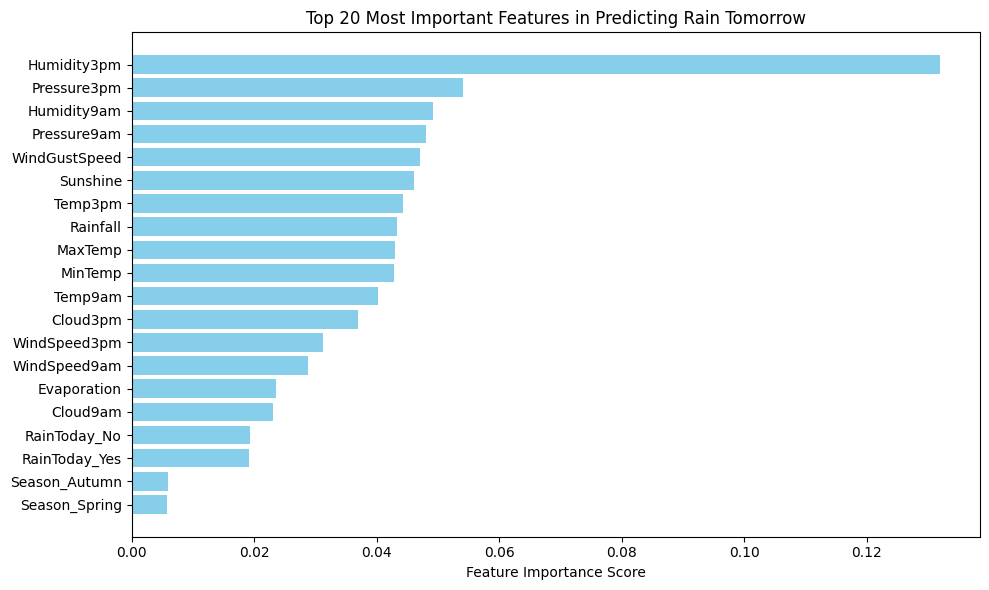

In [43]:
# Extract the trained classifier and get feature importances
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Get feature names from numeric and one-hot encoded categorical features
numeric_feature_names = numerical_features
categorical_feature_names = best_model.named_steps['preprocessing'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_features)

# Combine all feature names
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Create a DataFrame for sorting and plotting
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select top N features to display
N = 20
top_features = importance_df.head(N)

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Most important on top
plt.title(f'Top {N} Most Important Features in Predicting Rain Tomorrow')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()


### Observations

- The model heavily relies on short-term atmospheric indicators like humidity, pressure, and wind speed to predict rainfall the next day.
- Humidity at 3pm emerged as the single most important feature — suggesting that late-day moisture buildup is a strong signal for next-day precipitation.
- Categorical indicators such as `RainToday` and `Season` contributed less to the model’s decision-making process, indicating that real-time weather variables carried more predictive weight than recent rainfall or seasonal trends.

These insights reinforce the value of sensor-driven weather inputs and suggest potential directions for feature prioritization in future modeling tasks.


## Bonus Model: Logistic Regression Classifier

To complement the Random Forest model, we trained a logistic regression classifier using the same preprocessing pipeline. Logistic regression offers a simpler, interpretable baseline and can be effective for binary classification problems, especially when the feature set is well-prepared.

In this section, we use `GridSearchCV` to tune key hyperparameters (`penalty` and `class_weight`) and compare the performance of logistic regression against the previously optimized random forest classifier.

In [ ]:


# Define a new pipeline with Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Define a simple parameter grid
lr_param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']
}

# Set up GridSearchCV
lr_grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=lr_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
lr_grid_search.fit(X_train, y_train)

# Get predictions
lr_best_model = lr_grid_search.best_estimator_
y_pred_lr = lr_best_model.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


Logistic Regression Test Accuracy: 0.8500962463907603
Classification Report:
               precision    recall  f1-score   support

          No       0.87      0.95      0.91     22717
         Yes       0.73      0.50      0.60      6375

    accuracy                           0.85     29092
   macro avg       0.80      0.73      0.75     29092
weighted avg       0.84      0.85      0.84     29092



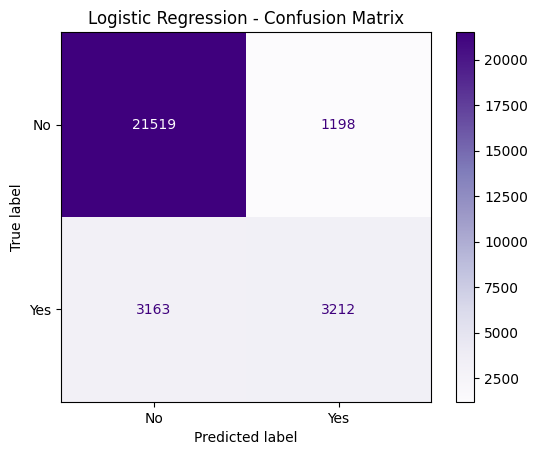

In [ ]:
# Model Evaluation

print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr_best_model.classes_)
disp_lr.plot(cmap="Purples")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


### Observations

While both models achieved similar accuracy (~85%) and recall for rainy days (0.50), the Random Forest model delivered slightly better precision (0.78 vs. 0.73) and F1-score (0.61 vs. 0.60) for the minority class. 

This suggests that Random Forest is better at identifying true positives while minimizing false alarms. However, logistic regression remains a valuable alternative due to its simplicity, speed, and interpretability — making it well-suited for environments with limited computational resources or explainability requirements.


## Conclusion and Recommendations

This project explored the use of supervised machine learning to predict whether it will rain tomorrow in Australia based on historical weather data. After preprocessing, feature engineering, and model training, two classification models were evaluated:

- A Random Forest classifier with optimized hyperparameters via GridSearchCV
- A Logistic Regression model serving as a baseline for comparison

### Key Findings:
- The Random Forest model achieved **85.8% accuracy** and a **recall of 0.50** for predicting rainy days, outperforming Logistic Regression across most metrics.
- Feature importance analysis revealed that **humidity, pressure, and wind speed**, particularly at 3pm, were the strongest predictors of rainfall.
- Logistic Regression performed similarly on recall but offered faster training and a simpler structure, making it a viable alternative for resource-constrained scenarios.

### Recommendations:
- For applications requiring higher recall on rainy days (e.g., agriculture, event planning), consider **tuning for F1-score** or **adjusting class weights** to reduce false negatives.
- Future work could explore:
  - Time-series-based features or temporal models
  - More advanced imputation strategies
  - Model ensembles or boosting methods (e.g., XGBoost, LightGBM)
  - Deployment as a weather-alert tool or forecasting API

This notebook demonstrates an end-to-end machine learning pipeline for binary classification and offers a practical approach to handling real-world weather data for predictive analytics.

---

For dataset, environment setup, and additional project notes, see the README.

---

This project is part of a broader portfolio which showcases practical applications of data science across analytics, visualization, and machine learning.  
For more projects, visit [My GitHub Portfolio](https://github.com/J1111-dotcom).

